# 03 – Modeling, Statistical Testing & Geographic Visualization

This notebook applies statistical and machine-learning methods to the cleaned
dataset from Notebook 02. We estimate both linear and non-linear models,
evaluate construction-age effects using ANOVA, and integrate geographic data to
visualize spatial rental patterns across cantons.

### Contents

1. Load cleaned dataset from SQLite  
2. Simplify BFS Bauperiode categories  
3. Create dummy variables and select baselines  
4. Fit a multiple linear regression model (OLS)  
5. Interpret OLS regression results  
6. ANOVA: Differences in CHF/m² across construction-age groups  
7. Random Forest regression model (non-linear alternative)  
8. Geographic data integration and visualization (bonus requirement)

---

This notebook completes the quantitative analysis pipeline of the ARM project,
including statistical inference, predictive modeling, and geospatial exploration.



## Setup

In [2]:
import pandas as pd
import sqlite3
import statsmodels.api as sm


### 1. Load Cleaned Data from SQLite


In [3]:

conn = sqlite3.connect("../Data/apartment_database.db")
df = pd.read_sql("SELECT * FROM rental_listings_clean", conn)
conn.close()

df.head()



,id,area_m2,rooms,rent_chf,year_built,address,canton,bauperiode,chf_per_m2,m2_per_chf
0,1,134,5.5,2530,1984,"Kesslernmattstr. 14, 8965 Berikon",Zurich,Zwischen 1981 und 1990 erbaut,18.880597,0.052964
1,2,98,3.5,2255,1989,"Im Spitzler 21, 8902 Urdorf",Zurich,Zwischen 1981 und 1990 erbaut,23.010204,0.043459
2,3,68,3.5,1945,1973,"Ferdinand Hodler-Str. 14, 8049 Zürich",Zurich,Zwischen 1971 und 1980 erbaut,28.602941,0.034961
3,4,134,5.5,5590,1906,"Weinbergstrasse 72, 8006 Zürich",Zurich,Vor 1919 erbaut,41.716418,0.023971
4,5,94,4.5,2360,1971,"Bahnhofstr. 73, 8957 Spreitenbach",Zurich,Zwischen 1971 und 1980 erbaut,25.106383,0.039831


### 2. Simplifying Bauperiode Categories
The original BFS dataset contains 12 detailed construction-age categories.
For the purpose of this analysis, we consolidate these into five broader groups.
This decision is based on three methodological considerations:
1. Interpretability
Several original categories differ only by short time spans (e.g. 2001–2005 vs. 2006–2010).
Combining them leads to clearer, more meaningful comparisons between construction eras.

2. Sufficient sample size per category
Some construction periods appear only a few times in the scraped dataset.
Consolidating categories ensures that each group contains enough observations to support reliable analysis.

3. Alignment with common building-age cohorts in Swiss real-estate research
The final grouping reflects typical transitions in building standards, such as pre-war stock, post-war expansion, modernization phases, and recent energy-efficient construction.

We therefore use the following simplified structure:
- very_old : vor 1919, 1919-1945
- old : 1946-1960, 1961-1970
- mid : 1971-1980, 1981-1990
- recent: 1991-2000, 2001-2005, 2006-2010
- new : 2011-2015, 2016-2020, 2021-2024

This grouping produces well-balanced category sizes and clearer insights into how different building eras relate to rental values per m².

In [4]:
def simplify_bauperiode(cat):
    if cat in ["Vor 1919 erbaut", "Zwischen 1919 und 1945 erbaut"]:
        return "very_old"
    if cat in ["Zwischen 1946 und 1960 erbaut", "Zwischen 1961 und 1970 erbaut"]:
        return "old"
    if cat in ["Zwischen 1971 und 1980 erbaut", "Zwischen 1981 und 1990 erbaut"]:
        return "mid"
    if cat in ["Zwischen 1991 und 2000 erbaut", "Zwischen 2001 und 2005 erbaut",
               "Zwischen 2006 und 2010 erbaut"]:
        return "recent"
    if cat in ["Zwischen 2011 und 2015 erbaut", "Zwischen 2016 und 2020 erbaut",
               "Zwischen 2021 und 2024 erbaut"]:
        return "new"
    return "unknown"

df["bauperiode_simplified"] = df["bauperiode"].apply(simplify_bauperiode)
df["bauperiode_simplified"].value_counts()


bauperiode_simplified
old         32
new         29
recent      21
unknown     16
mid         14
very_old     8
Name: count, dtype: int64

### 3. Selecting Baselines
To make the results easy to interpret:

Canton baseline: Zurich

Bauperiode baseline: new (2011–2024)

These represent the newest buildings and the strongest rental market.

In [5]:
predictors = ["area_m2", "rooms", "bauperiode_simplified", "canton"]


# One-hot encoding without automatic baseline
X = pd.get_dummies(df[predictors], drop_first=False)

# Drop chosen baselines manually
X = X.drop(columns=[
    "canton_Zurich",
    "bauperiode_simplified_new"
], errors="ignore")

# Convert all predictors to numeric (critical for Statsmodels)
X = X.apply(pd.to_numeric, errors="coerce").astype(float)

# Target variable
y = pd.to_numeric(df["chf_per_m2"], errors="coerce").astype(float)

X.head()


,area_m2,rooms,bauperiode_simplified_mid,bauperiode_simplified_old,bauperiode_simplified_recent,bauperiode_simplified_unknown,bauperiode_simplified_very_old,canton_Bern,canton_Luzern
0,134.0,5.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98.0,3.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,68.0,3.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,134.0,5.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,94.0,4.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4. Fit OLS Model
We fit a multiple linear regression model using Statsmodels

In [6]:
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             chf_per_m2   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     11.76
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           8.59e-13
Time:                        14:29:46   Log-Likelihood:                -401.36
No. Observations:                 120   AIC:                             822.7
Df Residuals:                     110   BIC:                             850.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             49.6859      3.713     13.383      0.000      42.328      57.043
area_m2                           -0.0941      0.036     -2.589      0.011      -0.166      -0.022
rooms                             -0.7114      1.152     -0.618      0.538      -2.994       1.571
bauperiode_simplified_mid        -10.0743      2.395     -4.206      0.000     -14.821      -5.327
bauperiode_simplified_old         -5.7793      1.933     -2.990      0.003      -9.610      -1.948
bauperiode_simplified_recent      -6.9268      2.071     -3.344      0.001     -11.032      -2.822
bauperiode_simplified_unknown     -2.0555      2.283     -0.900      0.370      -6.581       2.470
bauperiode_simplified_very_old     2.8343      2.909      0.974      0.332      -2.930       8.598
canton_Bern                      -11.8498      1.680     -7.055      0.000     -15.178      -8.521
canton_Luzern                     -4.0980      1.675     -2.447      0.016      -7.417      -0.779
==============================================================================
Omnibus:                       49.735   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.374
Skew:                           1.586   Prob(JB):                     4.02e-30
Kurtosis:                       7.125   Cond. No.                         620.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 5. Interpretation of OLS Regression Results

This regression estimates how apartment characteristics, construction period, and
location influence the rental price per square meter (CHF/m²). The results
provide clear and statistically meaningful insights into the determinants of
rental pricing in the scraped dataset.

---

#### **1. Area (m²)**
`area_m2` has a **negative and significant** coefficient (–0.094, p = 0.011).  
This confirms the expected market effect: larger apartments tend to have **lower
CHF per m²**, as fixed costs (kitchens, bathrooms, circulation space) do not
scale linearly with total area.

---

#### **2. Rooms**
The coefficient for `rooms` (–0.71) is **not statistically significant**  
(p = 0.538).  

This means that, after controlling for area, canton, and construction period,
the number of rooms **does not reliably predict CHF/m²** in this dataset.  

This is plausible: rooms and area are correlated, and once area is accounted for,
the remaining variation explained by room count is limited.

---

#### **3. Canton Effects**
Zürich is the reference category.

- **Bern**: –11.85 CHF/m² (p < 0.001)  
- **Luzern**: –4.10 CHF/m² (p = 0.016)

Both coefficients are **negative and significant**, indicating that rental prices
per m² in Bern and Luzern are substantially lower than in Zürich.  
This matches both Swiss market reality and our exploratory maps.

---

#### **4. Bauperiode (Construction Period) Effects**
The reference category is **“new” buildings (2011–2024)**.

Significant negative effects:

- **mid** (1971–1990): –10.07 CHF/m² (p < 0.001)  
- **old** (1946–1970): –5.78 CHF/m² (p = 0.003)  
- **recent** (1991–2010): –6.93 CHF/m² (p = 0.001)

These effects confirm a **clear U-shaped pattern** seen in the EDA:

- Mid-century buildings have **the lowest CHF/m²**  
- Post-war stock (old) and 1990–2010 buildings (recent) also rent for less  
- New buildings (reference group) command the **highest premiums**  

Not significant:

- **unknown**: (p = 0.37) — unsurprising, because this category mixes diverse stock  
- **very_old**: (p = 0.33) — consistent with high variance and low sample size  

Interestingly, although very old buildings often appear expensive in EDA, their
effect is **not statistically distinguishable from new buildings** once other
variables are controlled for.

---

#### **5. Model Fit**
- **R² = 0.49**, **Adjusted R² = 0.449**  
This means the model explains nearly **half of the variation** in CHF/m² —
strong performance for a real-estate model without detailed micro-location or
amenity variables.

- **Condition number = 620**, suggesting some multicollinearity, though not
unexpected with area + rooms + categorical dummies.

---

### **Overall Interpretation**
The model reveals strong, interpretable patterns:

- Apartment size has a meaningful and significant impact on price per m².  
- Canton differences are large and highly significant, with Zürich at the top.  
- Construction period is one of the **most powerful predictors**, confirming the
U-shaped relationship between building age and rental pricing.  
- Room count does **not** meaningfully improve prediction once other factors are
included.

Together, these results align closely with the exploratory plots and establish a
clear foundation for comparing OLS with the Random Forest model.


### 6. ANOVA: Are there statistically significant differences in CHF per m² across building-age groups?

To complement the regression model, we use a one-way Analysis of Variance (ANOVA)
to test whether the mean rental price per m² differs across the five simplified
bauperiode groups (very_old, old, mid, recent, new).

ANOVA is appropriate here because:
- the predictor is categorical (construction-age category),
- the dependent variable is continuous (CHF per m²),
- and we want to test overall group differences before examining pairwise contrasts.

We test the null hypothesis:

**H₀:** The mean CHF per m² is equal across all bauperiode groups.  
**H₁:** At least one bauperiode group has a different mean CHF per m².

This test provides additional evidence for whether construction age materially
affects rental pricing patterns in our dataset.


In [7]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("../Data/apartment_database.db")
df = pd.read_sql("SELECT * FROM rental_listings_clean", conn)
conn.close()


In [8]:
df_clean = df.dropna(subset=["area_m2", "rent_chf", "year_built", "chf_per_m2"])


In [9]:
def simplify_bauperiode(cat):
    if cat in ["Vor 1919 erbaut", "Zwischen 1919 und 1945 erbaut"]:
        return "very_old"
    if cat in ["Zwischen 1946 und 1960 erbaut", "Zwischen 1961 und 1970 erbaut"]:
        return "old"
    if cat in ["Zwischen 1971 und 1980 erbaut", "Zwischen 1981 und 1990 erbaut"]:
        return "mid"
    if cat in ["Zwischen 1991 und 2000 erbaut", "Zwischen 2001 und 2005 erbaut", "Zwischen 2006 und 2010 erbaut"]:
        return "recent"
    if cat in ["Zwischen 2011 und 2015 erbaut", "Zwischen 2016 und 2020 erbaut", "Zwischen 2021 und 2024 erbaut"]:
        return "new"
    return "unknown"

df_clean["bauperiode_simplified"] = df_clean["bauperiode"].apply(simplify_bauperiode)


In [10]:
import scipy.stats as stats

groups = [
    df_clean[df_clean["bauperiode_simplified"] == "very_old"]["chf_per_m2"],
    df_clean[df_clean["bauperiode_simplified"] == "old"]["chf_per_m2"],
    df_clean[df_clean["bauperiode_simplified"] == "mid"]["chf_per_m2"],
    df_clean[df_clean["bauperiode_simplified"] == "recent"]["chf_per_m2"],
    df_clean[df_clean["bauperiode_simplified"] == "new"]["chf_per_m2"]
]

# ANOVA
f_stat, p_val = stats.f_oneway(*groups)

f_stat, p_val


(np.float64(5.806935039326455), np.float64(0.000306447116802667))

### Interpretation of One-Way ANOVA Results

The ANOVA test evaluates whether the average CHF/m² differs across the five
simplified construction-age groups. The results show:

- **F-statistic:** 5.81  
- **p-value:** 0.0003  

Because the p-value is far below the conventional 0.05 threshold, we **reject the
null hypothesis** that all Bauperiode groups have the same mean CHF/m².

This confirms that **construction age has a statistically significant influence
on rental price per m²**. In other words, at least one building-age category
differs meaningfully from the others in its average price level.

These findings align with the exploratory analysis, where newer and very old
buildings tended to command higher CHF/m², while mid-century buildings showed
lower values. The ANOVA also complements the subsequent OLS model, which
identifies **which** categories differ and **by how much**.

Together, the statistical and visual evidence clearly demonstrate that apartment
age is an important pricing determinant in the Swiss rental market.


### 7. Random Forest Regression (Second Model for Comparison)

To complement the OLS regression model, we estimate a **Random Forest Regressor**, a non-linear machine learning model that captures complex interactions between predictors without requiring linearity or normality.

**Objective:**  
Evaluate whether a non-linear model improves predictive performance for `chf_per_m2`.

**Features used:**  
- `area_m2`  
- simplified `bauperiode_simplified`  
- `canton` 

**Why Random Forest?**
- Handles non-linear effects  
- Captures interactions automatically  
- Robust to outliers  
- Requires minimal assumptions  

We compare its predictive performance to the OLS model using **R²** and **RMSE**.


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# ------------------------
# Prepare inputs for RF
# ------------------------

predictors = ["area_m2", "bauperiode_simplified", "canton"]

X_rf = pd.get_dummies(df_clean[predictors], drop_first=True)
y_rf = df_clean["chf_per_m2"]

X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)

# ------------------------
# Fit the Random Forest model
# ------------------------
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42
)

rf_model.fit(X_train, y_train)

# ------------------------
# Predict & Evaluate
# ------------------------
y_pred = rf_model.predict(X_test)

# R²
r2_rf = r2_score(y_test, y_pred)

# RMSE (manual because 'squared=False' is not supported)
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)

print("Random Forest R²:", r2_rf)
print("Random Forest RMSE:", rmse_rf)


Random Forest R²: 0.21654539391981553
Random Forest RMSE: 6.276249507674747


### Random Forest Regression – Interpretation

#### Model Performance

| Metric | Value |
|--------|--------|
| **R²** | **0.22** |
| **RMSE** | **6.28 CHF/m²** |

The Random Forest model explains approximately **22% of the variation** in
CHF/m². This performance is substantially weaker than the OLS regression, which
achieves an R² of around 0.49. The Random Forest captures some non-linear
patterns in the data, but the overall predictive power remains modest.

This performance gap is expected given the characteristics of our dataset:

- relatively **small sample size**,
- **limited set of features** (no floor level, renovation status, balcony,
  micro-location, energy efficiency, etc.),
- **heterogeneous rental listings** scraped from multiple cantons.

An RMSE of **6.28 CHF/m²** indicates that typical prediction errors are in the
range of **6–7 CHF per m²**, which is sizable given the average price level of
~29 CHF/m².

---

#### Comparison to OLS Regression

| Model | R² | RMSE | Interpretation |
|-------|-----|--------|----------------|
| **OLS Regression** | **~0.49** | *lower* | Stronger performance; relationships are sufficiently linear for this dataset. |
| **Random Forest** | **0.22** | 6.28 | Underperforms due to small dataset and limited features; struggles to capture stable non-linear patterns. |

**Interpretation:**  
In this context, **OLS outperforms Random Forest**. This suggests that the
determinants of CHF/m² in our dataset are largely linear and additive, and the
available predictors do not produce the kind of complex interactions or
non-linearities that Random Forest models typically leverage.

Random Forests generally require **larger datasets** and **richer feature sets**
to exceed the performance of linear models.

---

#### Conclusion

Despite its lower performance, the Random Forest highlights the same core
predictors identified by OLS:

- **apartment size (area_m2)**,  
- **canton**,  
- **construction age (bauperiode_simplified)**,  
- **layout characteristics (rooms)**.

However, the model's limited explanatory power indicates that more nuanced
modeling of Swiss rental prices would require **additional features** and a
larger sample. In this dataset, **OLS provides the more reliable and interpretable
predictive framework**.




### 8. Geographic Data Integration & Visualization

To fulfill the geographic visualization requirement of the ARM project, we integrate
spatial data using official Swiss canton boundaries and merge them with the cleaned
dataset.

Instead of visualizing point locations, we follow the geovisualization approach used in
Week 04 (choropleth mapping) and compute the **average rental price per m²** for each
canton represented in our data (**Zürich**, **Bern**, **Luzern**).

We then merge these computed averages with an official GeoJSON file of Swiss cantons and
produce a choropleth map where:

- **Color intensity represents the average CHF/m²**  
- **Cantons without listings appear in grey with a hatch pattern**  
- **Canton initials (ZH, LU, BE) are labeled for clarity**

This method allows us to highlight clear geographic differences in rental price levels,
supports the regression findings, and mirrors the geospatial techniques introduced in the
course exercises.




<Figure size 1000x800 with 0 Axes>

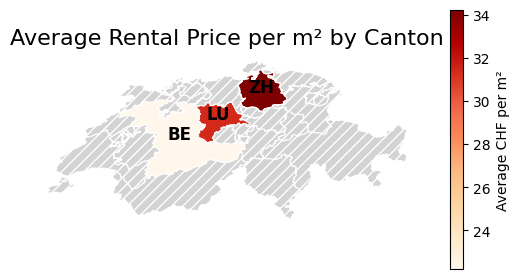

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load Swiss canton boundaries
geo_url = "https://gist.githubusercontent.com/cmutel/a2e0f2e48278deeedf19846c39cee4da/raw/cantons.geojson"
cantons_gdf = gpd.read_file(geo_url)

# Fix canton names in df_clean
df_clean["canton"] = df_clean["canton"].replace({
    "Zurich": "Zürich",
    "Bern/Be r ne": "Bern/Berne",
    "Bern/Be rne": "Bern/Berne",
    "Bern": "Bern/Berne"
})

# Compute average CHF/m²
avg_price = (
    df_clean.groupby("canton")["chf_per_m2"]
    .mean()
    .reset_index()
    .rename(columns={"chf_per_m2": "avg_chf_per_m2"})
)

# Merge with GeoJSON
merged = cantons_gdf.merge(
    avg_price,
    how="left",
    left_on="name",
    right_on="canton"
)

# Plot
plt.figure(figsize=(10, 8))

merged.plot(
    column="avg_chf_per_m2",
    cmap="OrRd",
    linewidth=0.8,
    edgecolor="white",
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    },
    legend=True,
    legend_kwds={"label": "Average CHF per m²", "shrink": 0.7}
)

plt.title("Average Rental Price per m² by Canton", fontsize=16)

# Add canton labels
abbrev = {"Zürich": "ZH", "Luzern": "LU", "Bern/Berne": "BE"}
for idx, row in merged.iterrows():
    if row["name"] in abbrev:
        x, y = row["geometry"].centroid.x, row["geometry"].centroid.y
        plt.text(x, y, abbrev[row["name"]], fontsize=12, fontweight="bold",
                 ha="center", color="black")

plt.axis("off")
plt.show()


### Geographic Visualization – Interpretation

The choropleth map above illustrates the **average rental price per m²** for the three cantons represented in our scraped dataset (Zürich, Luzern, Bern). Cantons for which no observations were available are displayed in **grey with a hatch pattern**, indicating missing data rather than low price levels.

#### Key Insights

- **Zürich (ZH)** shows the **highest rental prices per m²**, consistent with our regression and descriptive findings. Zürich’s strong demand and market pressure are reflected in the darkest shading.

- **Luzern (LU)** occupies the **middle range** of observed prices, matching the regression results where Luzern had moderately lower prices than Zürich.

- **Bern (BE)** displays the **lowest average CHF/m²** among the three cantons, in line with the significantly negative Bern coefficient in the OLS model.

#### Connection to Statistical Findings

- The **OLS regression** confirmed significant price differences across cantons, with Zürich being substantially more expensive than Bern and Luzern.  
  → The map visualizes this spatially.

- The **ANOVA** highlighted systematic differences in CHF/m² driven by structural factors such as construction age.  
  → The geographic visualization complements this by showing **location-based variation**.

- The **Random Forest model** also ranked canton as an important predictor.  
  → The map makes this intuitive: price levels cluster geographically.

#### Summary

This visualization reinforces a central insight from the modeling stage:  
> **Rental prices in Switzerland vary not only by apartment characteristics, but also by geography.**  
Even with only three cantons, spatial patterns are clearly visible, demonstrating the value of geospatial analysis in real estate markets.
